In [1]:
# single

In [2]:
# dependency
import numpy as np
import pandas as pd
import copy
import math
import sys
import os
from activations import relu, leaky_relu, sigmoid, tanh, softmax, d_sigmoid, d_relu
from initializers import glorot_uniform, random_normal, random_uniform
from regularizers import l1_regularizer, l2_regularizer
from utility import trim_tail, multiply, subtract, get_nparams, one_hot_encoding, get_data
from metrics import MSE, CCE, ACC, PRECISION, RECALL, essential_metrics, wondering_penalty, close_gap_penalty
from pso import PSO
from ga import GA
from nn import Network
from layer import DenseLayer
from scalers import MinMaxScaler, StandardScaler

In [3]:
# reference
metrics_fn_dict = dict()
metrics_fn_dict['accuracy'] = ACC
metrics_fn_dict['categorical_crossentropy'] = CCE
metrics_fn_dict['mean_square_error'] = MSE
metrics_fn_dict['precision'] = PRECISION
metrics_fn_dict['recall'] = RECALL
metrics_fn_dict['essential_metrics'] = essential_metrics

In [4]:
# model
model = Network(5, lr = None)
model.add_layer(DenseLayer(1, 4, True, afn=sigmoid, dafn=None, rfn=None))
model.add_layer(DenseLayer(2, 3, True, afn=softmax, dafn=None, rfn=None))

In [5]:
# optimizer
ga = GA(
    dict(
        m = 50,
        x_rate = [0.5, 1.0],
        m_rate = [0.5, 1.0],
        weight_constraint = [-3.,3.],
        radioactive_rating = [0.1, 0.5],
        grow_factor = [0.1, 0.5],
        scale_hyperparameter = False,
        regularizer = None))

In [6]:
model.compile(loss_fn = 'categorical_crossentropy', optimizer = ga, \
    metrics = ['accuracy', 'mean_square_error', 'categorical_crossentropy', 'precision', 'recall', 'f1'])

building layer 1 with 5
24
building layer 2 with 4
15


In [7]:
# data loading
DATA = os.path.join('c:\\Users\\tcumi\\github_repo\\neural-network\\', 'dataset')
GROUP = 1
COLUMNS = ['f1', 'f2', 'f3', 'f4', 'f5', 'label']
N_CLASS = 3
EPOCHS = 500
train_dir, test_dir = "..//dataset//training_data{}.txt".format(GROUP), "..//dataset//testing_data{}.txt".format(GROUP)
train, test = get_data(DATA, train_dir, COLUMNS), get_data(DATA, test_dir, COLUMNS)
# shuffle
train, test = train.sample(frac=1), test.sample(frac=1)
x_train, y_train = train.drop('label', axis=1), train['label']
x_test, y_test = test.drop('label', axis=1), test['label']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107 entries, 0 to 106
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   f1      107 non-null    float32
 1   f2      107 non-null    float32
 2   f3      107 non-null    float32
 3   f4      107 non-null    float32
 4   f5      107 non-null    float32
 5   label   107 non-null    float32
dtypes: float32(6)
memory usage: 2.6 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108 entries, 0 to 107
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   f1      108 non-null    float32
 1   f2      108 non-null    float32
 2   f3      108 non-null    float32
 3   f4      108 non-null    float32
 4   f5      108 non-null    float32
 5   label   108 non-null    float32
dtypes: float32(6)
memory usage: 2.7 KB
None


In [8]:
# data scaling and encoding
scaler = StandardScaler(['f1', 'f2', 'f3', 'f4', 'f5'])
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)
y_train = one_hot_encoding(y_train, N_CLASS)
y_test = one_hot_encoding(y_test, N_CLASS)

In [9]:
# learning phase
breakpoint = 100
checkpoints = list()
history = list()
for century in range(0, EPOCHS, breakpoint):
    sub_history = model.fit(x_train, y_train, breakpoint, verbose = 0)
    score = model.evaluate(x_test, y_test, False, verbose = 0)
    print('Checkpoint {}, Accuracy: {}, Loss: {}'.format(century+breakpoint, score['accuracy'], score[model.loss_fn]))
    score['checkpoint'] = century + breakpoint
    checkpoints.append(score)
    history.extend(sub_history)
    itr = century + breakpoint

    model.optimizer.rr = model.optimizer.radioactive_rating[1] - (model.optimizer.radioactive_rating[1] - model.optimizer.radioactive_rating[0]) / EPOCHS * (EPOCHS - itr)
    model.optimizer.gf = model.optimizer.grow_factor[1] - (model.optimizer.grow_factor[1] - model.optimizer.grow_factor[0]) / EPOCHS * (EPOCHS - itr)
    model.optimizer.crossover_rate = model.optimizer.x_rate[1] - (model.optimizer.x_rate[1] - model.optimizer.x_rate[0]) / EPOCHS * (EPOCHS - itr)
    model.optimizer.mutation_rate = model.optimizer.m_rate[0] + (model.optimizer.m_rate[1] - model.optimizer.m_rate[0]) / EPOCHS * (EPOCHS - itr)
    

C:\Users\tcumi\github_repo\neural-network\python\ga.py:201: RuntimeWarning: overflow encountered in add
  self.population.sort(key=lambda p: p.fitness + np.random.uniform(-shift, shift, 1), reverse = self.aim)


Checkpoint 100, Accuracy: 0.9691358024691358, Loss: 0.2643750685232657
Checkpoint 200, Accuracy: 0.9567901234567902, Loss: 0.2270096849512171
Checkpoint 300, Accuracy: 0.9629629629629629, Loss: 0.19192089857878508
Checkpoint 400, Accuracy: 0.9506172839506173, Loss: 0.17639361487494576
Checkpoint 500, Accuracy: 0.9567901234567902, Loss: 0.15350433632179541


In [10]:
import matplotlib.pyplot as plt

def draw_plot(x, y_list, x_label=None, y_label=None, legend=None, title=None):
    fig, ax = plt.subplots(figsize=(12,5))
    for xi, yi in zip(x, y_list):
        ax.plot(xi, yi)
    if x_label is not None and y_label is not None:
        ax.set(xlabel=x_label, ylabel=y_label, title='{} VS {}'.format(x_label, y_label))
    if legend is not None:
        ax.legend(legend)
    ax.grid()
    plt.show()

In [11]:
# recall phase
score = model.evaluate(x_test, y_test, False)
print(score)

[1. 0. 0.] <-> [7.5107291e-02 2.2930182e-04 9.2466336e-01]
[1. 0. 0.] <-> [0.67896575 0.00102019 0.3200141 ]
[0. 1. 0.] <-> [2.915784e-02 9.708335e-01 8.680258e-06]
[0. 0. 1.] <-> [5.3418744e-02 1.2455657e-04 9.4645667e-01]
[1. 0. 0.] <-> [0.9887916  0.00740765 0.0038008 ]
[1. 0. 0.] <-> [0.9801538  0.01819809 0.00164809]
[1. 0. 0.] <-> [0.9852632  0.00370304 0.01103373]
[1. 0. 0.] <-> [0.9813136  0.00238766 0.01629867]
[1. 0. 0.] <-> [0.9856705  0.01232244 0.00200702]
[1. 0. 0.] <-> [0.9869016  0.00323781 0.00986068]
[1. 0. 0.] <-> [0.96190244 0.00163025 0.03646727]
[1. 0. 0.] <-> [0.9880292  0.00383099 0.00813987]
[0. 0. 1.] <-> [6.4640805e-02 1.4044462e-04 9.3521875e-01]
[1. 0. 0.] <-> [0.9425288  0.00603892 0.0514323 ]
[1. 0. 0.] <-> [0.9836776  0.01205859 0.0042638 ]
[1. 0. 0.] <-> [0.98789036 0.00657134 0.00553824]
[1. 0. 0.] <-> [0.89779496 0.00102506 0.10117994]
[0. 0. 1.] <-> [0.04876493 0.01426493 0.9369701 ]
[1. 0. 0.] <-> [6.4960116e-01 3.4990349e-01 4.9526693e-04]
[1. 0. 0

In [12]:
# Testing Performance

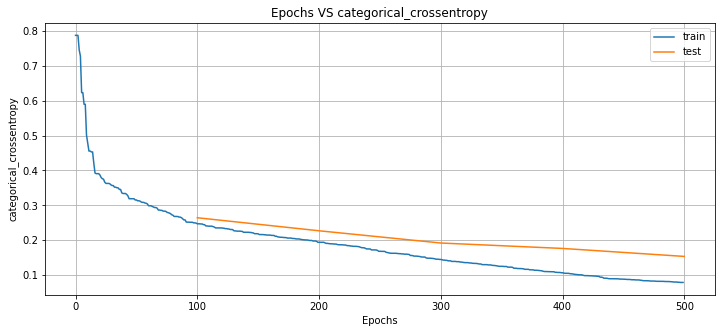

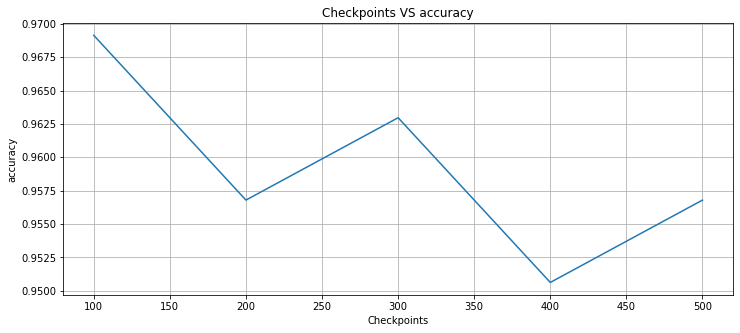

In [13]:
draw_plot(x = [[i for i in range(len(history))], [(i+1)*breakpoint for i in range(len(checkpoints))]], y_list = [history, [ ckp[model.loss_fn] for ckp in checkpoints ]], x_label = 'Epochs', \
    y_label = model.loss_fn, legend=['train', 'test'])
acc = [ ckp['accuracy'] for ckp in checkpoints ]
draw_plot(x = [[(i+1)*breakpoint for i in range(len(checkpoints))]], y_list = [acc], x_label = 'Checkpoints', \
    y_label = 'accuracy')

In [14]:
for checkpoint in checkpoints:
    print(checkpoint, '\n\n')

{'accuracy': 0.9691358024691358, 'mean_square_error': 0.12944733291706256, 'categorical_crossentropy': 0.2643750685232657, 'precision': 0.9537037037037037, 'recall': 0.9537037037037037, 'f1': 0.9537037037037037, 'essential_metrics': {0: {'tp_hit': 78, 'fp_hit': 3, 'tn_hit': 25, 'fn_hit': 2}, 1: {'tp_hit': 13, 'fp_hit': 0, 'tn_hit': 93, 'fn_hit': 2}, 2: {'tp_hit': 12, 'fp_hit': 2, 'tn_hit': 93, 'fn_hit': 1}}, 'checkpoint': 100} 


{'accuracy': 0.9567901234567902, 'mean_square_error': 0.11124588036521052, 'categorical_crossentropy': 0.2270096849512171, 'precision': 0.9351851851851852, 'recall': 0.9351851851851852, 'f1': 0.9351851851851852, 'essential_metrics': {0: {'tp_hit': 77, 'fp_hit': 4, 'tn_hit': 24, 'fn_hit': 3}, 1: {'tp_hit': 12, 'fp_hit': 0, 'tn_hit': 93, 'fn_hit': 3}, 2: {'tp_hit': 12, 'fp_hit': 3, 'tn_hit': 92, 'fn_hit': 1}}, 'checkpoint': 200} 


{'accuracy': 0.9629629629629629, 'mean_square_error': 0.09797255475883225, 'categorical_crossentropy': 0.19192089857878508, 'precisi

In [15]:
print(model)

Layer 1
Neuron 0: weights:
[-0.30418545  2.5679312  -0.27610716 -0.7096194  -2.901782  ]
 bias: 2.1614625453948975

Neuron 1: weights:
[ 2.2539935 -3.        -2.766709  -0.8557583 -2.2408316]
 bias: 1.0275774002075195

Neuron 2: weights:
[ 0.7892846  1.52314    1.5565146 -1.0322129 -2.6957796]
 bias: -1.3729116916656494

Neuron 3: weights:
[ 0.42140782 -1.9810193   0.43339562 -0.36044258  2.8628802 ]
 bias: 0.08973453938961029

$
Layer 2
Neuron 0: weights:
[ 2.9135206   3.          0.48421016 -0.2185903 ]
 bias: -1.9569692611694336

Neuron 1: weights:
[ 2.4215465 -3.         3.        -3.       ]
 bias: -0.40451669692993164

Neuron 2: weights:
[-3.         2.8995833 -1.5103531  3.       ]
 bias: -2.2199151515960693

$

